In [ ]:
import pandas as pd
import pandas as pd
import time
import re
import random
import os
from tqdm.auto import tqdm
import openai
import backoff
import concurrent.futures
from getpass import getpass

# Configure batch processing
MAX_WORKERS = 10  # Number of parallel requests - adjust based on your API limits
BATCH_SIZE = 50  # Process results in batches for saving
SAMPLE_SIZE = 4000  # Number of statements to label in total

# Configure file paths
INPUT_FILE = "vp_primary_debates_by_statement.csv"  # Input CSV from scraper
OUTPUT_FILE = "vp_primary_debates_with_hostility.csv"  # Final output file
CHECKPOINT_FILE = "hostility_annotation_progress.csv"  # Save progress frequently

# Function with exponential backoff for handling rate limits
@backoff.on_exception(backoff.expo,
                     Exception,  # Catch all exceptions
                     max_tries=3,
                     factor=2)
def classify_hostility(statement, client):
    """Classify hostility with retry logic for rate limits"""
    prompt = (
        "You are a political analyst. Label the following political debate statement for hostility.\\n\\n"
        "Label definitions:\\n"
        "2 = Very hostile (clearly attacking, highly negative, aggressive)\\n"
        "1 = Somewhat or maybe hostile (mildly negative, critically questioning, passive-aggressive)\\n"
        "0 = Not hostile at all (neutral, informative, collaborative)\\n\\n"
        f"Statement: \"{statement}\"\\n"
        "Hostility label (just a number):"
    )

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",  # Faster than GPT-4 #consider
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=10  # We only need a short response
    )

    # Extract the first digit 0, 1, or 2 from the response
    output = response.choices[0].message.content.strip()
    match = re.search(r"\b[012]\b", output)
    if match:
        return int(match.group(0))
    else:
        print(f"Could not parse label from response: {output}")
        return None

def process_statements(statements, indices, client):
    """Process a batch of statements and return results"""
    results = []
    for idx, statement in zip(indices, statements):
        try:
            label = classify_hostility(statement, client)
            results.append((idx, label))
            # Small delay to avoid clustering requests too closely
            time.sleep(0.1)
        except Exception as e:
            print(f"Error on statement {idx}: {str(e)}")
            results.append((idx, None))
    return results

def main():
    # Get API key
    api_key = getpass("Enter your OpenAI API key: ")
    client = openai.OpenAI(api_key=api_key)

    # Test API connection
    print("Testing API connection...")
    try:
        test_result = classify_hostility("This is a test statement.", client)
        print(f"API test successful. Result: {test_result}")
    except Exception as e:
        print(f"API test failed: {str(e)}")
        print("Please check your API key and try again.")
        return

    # Load the dataset
    print(f"Loading dataset from {INPUT_FILE}...")
    try:
        df = pd.read_csv(INPUT_FILE)
        print(f"Loaded {len(df)} statements.")
    except FileNotFoundError:
        print(f"Error: {INPUT_FILE} not found. Please run the scraper first.")
        return
    except Exception as e:
        print(f"Error loading CSV: {str(e)}")
        return

    # Try to load previous progress if available
    try:
        df_annotated = pd.read_csv(CHECKPOINT_FILE)
        print(f"Loaded previous progress with {df_annotated['hostility_label'].notna().sum()} labeled statements")
    except FileNotFoundError:
        print("Starting fresh annotation")
        df_annotated = df.copy()
        if 'hostility_label' not in df_annotated.columns:
            df_annotated['hostility_label'] = None

    # Create a list of indices that still need processing
    remaining_indices = df_annotated[df_annotated['hostility_label'].isna()].index.tolist()

    # Sample statements if requested
    total_remaining = len(remaining_indices)
    if total_remaining > SAMPLE_SIZE:
        print(f"Randomly sampling {SAMPLE_SIZE} statements from {total_remaining} remaining unlabeled statements")
        selected_indices = random.sample(remaining_indices, SAMPLE_SIZE)
    else:
        print(f"Processing all {total_remaining} remaining unlabeled statements")
        selected_indices = remaining_indices

    # Create batches for processing
    batches = [selected_indices[i:i + BATCH_SIZE] for i in range(0, len(selected_indices), BATCH_SIZE)]
    print(f"Created {len(batches)} batches of up to {BATCH_SIZE} statements each")

    # Process all batches with progress bar
    start_time = time.time()
    processed_count = 0

    with tqdm(total=len(selected_indices), desc="Labeling statements") as pbar:
        for batch_idx, batch_indices in enumerate(batches):
            batch_statements = [df.loc[idx, 'statement'] for idx in batch_indices]

            # Process this batch using parallel workers
            with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                # Split the batch into smaller chunks for parallel processing
                chunk_size = max(1, len(batch_indices) // MAX_WORKERS)
                chunks_indices = [batch_indices[i:i + chunk_size] for i in range(0, len(batch_indices), chunk_size)]
                chunks_statements = [batch_statements[i:i + chunk_size] for i in range(0, len(batch_statements), chunk_size)]

                # Submit all chunks for parallel processing
                futures = [
                    executor.submit(process_statements, chunk_statements, chunk_indices, client)
                    for chunk_indices, chunk_statements in zip(chunks_indices, chunks_statements)
                ]

                # Collect results as they complete
                batch_results = []
                for future in concurrent.futures.as_completed(futures):
                    batch_results.extend(future.result())

            # Update dataframe with results
            for idx, label in batch_results:
                if label is not None:
                    df_annotated.loc[idx, 'hostility_label'] = label
                    processed_count += 1

            # Save progress after each batch
            df_annotated.to_csv(CHECKPOINT_FILE, index=False)

            # Update progress bar
            pbar.update(len(batch_indices))

            # Calculate and display time statistics
            elapsed_time = time.time() - start_time
            statements_per_second = processed_count / elapsed_time if elapsed_time > 0 else 0
            remaining_batches = len(batches) - (batch_idx + 1)
            estimated_remaining_time = remaining_batches * (elapsed_time / (batch_idx + 1)) if batch_idx > 0 else 0

            print(f"\nBatch {batch_idx+1}/{len(batches)} complete. "
                  f"Speed: {statements_per_second:.2f} statements/sec. "
                  f"Est. remaining time: {estimated_remaining_time/60:.1f} minutes.")

    # Final save
    df_annotated.to_csv(OUTPUT_FILE, index=False)

    # Show summary statistics
    hostility_counts = df_annotated['hostility_label'].value_counts()
    print("\nHostility Label Distribution:")
    print(hostility_counts)

    labeled_percent = df_annotated['hostility_label'].notna().mean() * 100
    print(f"\nPercentage labeled: {labeled_percent:.2f}%")

    total_time = time.time() - start_time
    print(f"\nTotal processing time: {total_time/60:.2f} minutes")
    print(f"Average speed: {processed_count/total_time:.2f} statements per second")
    print(f"Final output saved to: {OUTPUT_FILE}")

if __name__ == "__main__":
    main()

Enter your OpenAI API key: ··········
Testing API connection...
API test successful. Result: 0
Loading dataset from vp_primary_debates_by_statement.csv...
Loaded 45009 statements.
Starting fresh annotation
Randomly sampling 4000 statements from 45009 remaining unlabeled statements
Created 80 batches of up to 50 statements each


Labeling statements:   0%|          | 0/4000 [00:00<?, ?it/s]


Batch 1/80 complete. Speed: 15.94 statements/sec. Est. remaining time: 0.0 minutes.

Batch 2/80 complete. Speed: 15.12 statements/sec. Est. remaining time: 4.3 minutes.

Batch 3/80 complete. Speed: 14.27 statements/sec. Est. remaining time: 4.5 minutes.

Batch 4/80 complete. Speed: 14.13 statements/sec. Est. remaining time: 4.5 minutes.

Batch 5/80 complete. Speed: 14.44 statements/sec. Est. remaining time: 4.3 minutes.

Batch 6/80 complete. Speed: 14.48 statements/sec. Est. remaining time: 4.3 minutes.

Batch 7/80 complete. Speed: 14.51 statements/sec. Est. remaining time: 4.2 minutes.

Batch 8/80 complete. Speed: 14.69 statements/sec. Est. remaining time: 4.1 minutes.

Batch 9/80 complete. Speed: 11.35 statements/sec. Est. remaining time: 5.2 minutes.

Batch 10/80 complete. Speed: 9.98 statements/sec. Est. remaining time: 5.8 minutes.

Batch 11/80 complete. Speed: 10.10 statements/sec. Est. remaining time: 5.7 minutes.

Batch 12/80 complete. Speed: 10.38 statements/sec. Est. remaini

INFO:backoff:Backing off classify_hostility(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 41/80 complete. Speed: 10.77 statements/sec. Est. remaining time: 3.0 minutes.

Batch 42/80 complete. Speed: 10.84 statements/sec. Est. remaining time: 2.9 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 43/80 complete. Speed: 10.75 statements/sec. Est. remaining time: 2.9 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 44/80 complete. Speed: 10.57 statements/sec. Est. remaining time: 2.8 minutes.

Batch 45/80 complete. Speed: 10.65 statements/sec. Est. remaining time: 2.7 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 46/80 complete. Speed: 10.26 statements/sec. Est. remaining time: 2.8 minutes.

Batch 47/80 complete. Speed: 10.21 statements/sec. Est. remaining time: 2.7 minutes.

Batch 48/80 complete. Speed: 10.26 statements/sec. Est. remaining time: 2.6 minutes.

Batch 49/80 complete. Speed: 10.33 statements/sec. Est. remaining time: 2.5 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})



Batch 50/80 complete. Speed: 10.33 statements/sec. Est. remaining time: 2.4 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 51/80 complete. Speed: 10.30 statements/sec. Est. remaining time: 2.3 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 52/80 complete. Speed: 10.24 statements/sec. Est. remaining time: 2.3 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 53/80 complete. Speed: 10.22 statements/sec. Est. remaining time: 2.2 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 54/80 complete. Speed: 10.18 statements/sec. Est. remaining time: 2.1 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 55/80 complete. Speed: 10.11 statements/sec. Est. remaining time: 2.1 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 56/80 complete. Speed: 10.09 statements/sec. Est. remaining time: 2.0 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 57/80 complete. Speed: 10.05 statements/sec. Est. remaining time: 1.9 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 58/80 complete. Speed: 10.00 statements/sec. Est. remaining time: 1.8 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 59/80 complete. Speed: 9.98 statements/sec. Est. remaining time: 1.8 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 60/80 complete. Speed: 9.87 statements/sec. Est. remaining time: 1.7 minutes.

Batch 61/80 complete. Speed: 9.93 statements/sec. Est. remaining time: 1.6 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 62/80 complete. Speed: 9.91 statements/sec. Est. remaining time: 1.5 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 63/80 complete. Speed: 9.84 statements/sec. Est. remaining time: 1.4 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 64/80 complete. Speed: 9.77 statements/sec. Est. remaining time: 1.4 minutes.

Batch 65/80 complete. Speed: 9.82 statements/sec. Est. remaining time: 1.3 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 66/80 complete. Speed: 9.71 statements/sec. Est. remaining time: 1.2 minutes.

Batch 67/80 complete. Speed: 9.76 statements/sec. Est. remaining time: 1.1 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 68/80 complete. Speed: 9.67 statements/sec. Est. remaining time: 1.0 minutes.

Batch 69/80 complete. Speed: 9.70 statements/sec. Est. remaining time: 0.9 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 70/80 complete. Speed: 9.68 statements/sec. Est. remaining time: 0.9 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 71/80 complete. Speed: 9.66 statements/sec. Est. remaining time: 0.8 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 2.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 72/80 complete. Speed: 9.63 statements/sec. Est. remaining time: 0.7 minutes.


INFO:backoff:Backing off classify_hostility(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 73/80 complete. Speed: 9.59 statements/sec. Est. remaining time: 0.6 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 74/80 complete. Speed: 9.59 statements/sec. Est. remaining time: 0.5 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 0.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 75/80 complete. Speed: 9.52 statements/sec. Est. remaining time: 0.4 minutes.

Batch 76/80 complete. Speed: 9.39 statements/sec. Est. remaining time: 0.4 minutes.

Batch 77/80 complete. Speed: 9.40 statements/sec. Est. remaining time: 0.3 minutes.

Batch 78/80 complete. Speed: 9.45 statements/sec. Est. remaining time: 0.2 minutes.

Batch 79/80 complete. Speed: 9.48 statements/sec. Est. remaining time: 0.1 minutes.


INFO:backoff:Backing off classify_hostility(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-zq7Modopi4RhdMcJDgnrgDbv on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off classify_hostility(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit re


Batch 80/80 complete. Speed: 9.48 statements/sec. Est. remaining time: 0.0 minutes.

Hostility Label Distribution:
hostility_label
1    1988
0    1576
2     436
Name: count, dtype: int64

Percentage labeled: 8.89%

Total processing time: 7.04 minutes
Average speed: 9.47 statements per second
Final output saved to: vp_primary_debates_with_hostility.csv


In [ ]:
pip install backoff

Loaded dataset with 45009 statements
Columns: speaker, statement, party, debate_id, year, hostility_label

=== Hostility Label Distribution ===
hostility_label
0.0    1576
1.0    1988
2.0     436
Name: count, dtype: int64

Mean hostility score: 0.715
Statements with hostility > 0: 5.4%

=== Hostility Trends Over Time ===
    year  avg_hostility  count       std
0   1976       0.555556      9  0.527046
1   1984       1.083333     12  0.668558
2   1988       0.625000     16  0.806226
3   1992       0.529412     34  0.614733
4   1996       0.600000     10  0.516398
5   1999       0.647303    241  0.629222
6   2000       0.720126    318  0.669505
7   2004       0.670455     88  0.673327
8   2007       0.631265    838  0.605689
9   2008       0.651007    298  0.573561
10  2011       0.776978    417  0.650922
11  2012       0.785366    205  0.628397
12  2015       0.841026    390  0.676722
13  2016       0.777778    540  0.655126
14  2019       0.648402    438  0.672871
15  2020       0.6282

<ipython-input-4-067d4f8b2cf7>:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_speakers, x='avg_hostility', y='speaker', palette='Reds_r')
<ipython-input-4-067d4f8b2cf7>:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_speakers, x='avg_hostility', y='speaker', palette='Blues_r')



=== Most Hostile Statements ===
Sample of statements labeled as very hostile (2):

1. Speaker: TRUMP (2016)
   "The fact is — and if for some reason he beats the rest of the field, he beats the rest of the field [inaudible]. See, they don't like that. They don't..."

2. Speaker: CHRISTIE (2023)
   "No, you have to … either you are afraid or you're not listening."

3. Speaker: KAINE (2016)
   "Donald Trump always puts himself first. He built a business career, in the words of one of his own campaign staffers, "off the backs of the little guy..."

4. Speaker: MODERATORS (1999)
   "What's happened with the Fed, Karen, is typical of this "Washington first" attitude, of Washington setting the rules on how we should act. You see it ..."

5. Speaker: RUSSERT (2008)
   "You're going to be gone in a year, but you're going to leave a residual force behind? No. Get out. Get out now. If you don't want to stay and protect ..."

6. Speaker: BUSH (2015)
   "Hillary Clinton's approach to this is more

<ipython-input-4-067d4f8b2cf7>:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hostile_words.values, y=hostile_words.index, palette='Reds_r')
<ipython-input-4-067d4f8b2cf7>:229: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neutral_words.values, y=neutral_words.index, palette='Blues_r')



=== Statement Length Analysis ===
Statement length by hostility level:
   hostility_label        mean  median  count
0              0.0  134.949873    75.0   1576
1              1.0  232.919014   200.0   1988
2              2.0  224.458716   194.5    436

=== Statistical Analysis ===
T-test between VP and Republican:
  t-statistic: nan
  p-value: nan
  Significant difference: No
  Mean hostility VP: 0.697
  Mean hostility Republican: 0.779

T-test between VP and Democratic:
  t-statistic: nan
  p-value: nan
  Significant difference: No
  Mean hostility VP: 0.697
  Mean hostility Democratic: 0.635

T-test between Republican and Democratic:
  t-statistic: nan
  p-value: nan
  Significant difference: No
  Mean hostility Republican: 0.779
  Mean hostility Democratic: 0.635


=== Debate-level Hostility Analysis ===
Top 10 most hostile debates:
1. Debate ID: 2023_Republican_1206
   Average Hostility: 1.265
   Number of Statements: 49
2. Debate ID: 1984_VP_1011
   Average Hostility: 1.083
  

<ipython-input-4-067d4f8b2cf7>:319: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=debate_hostility.head(15), x='debate_id', y='avg_hostility', palette='Reds_r')



=== Generating Summary Report ===
Analysis complete! Report saved as 'hostility_analysis_report.md'


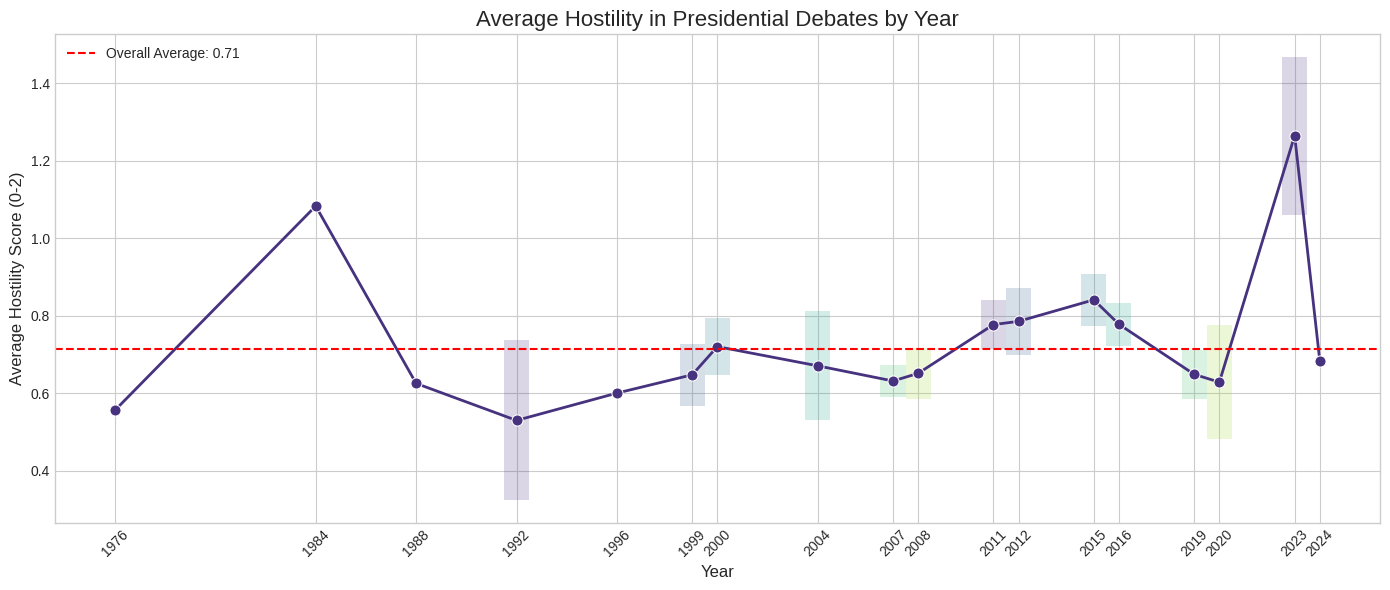

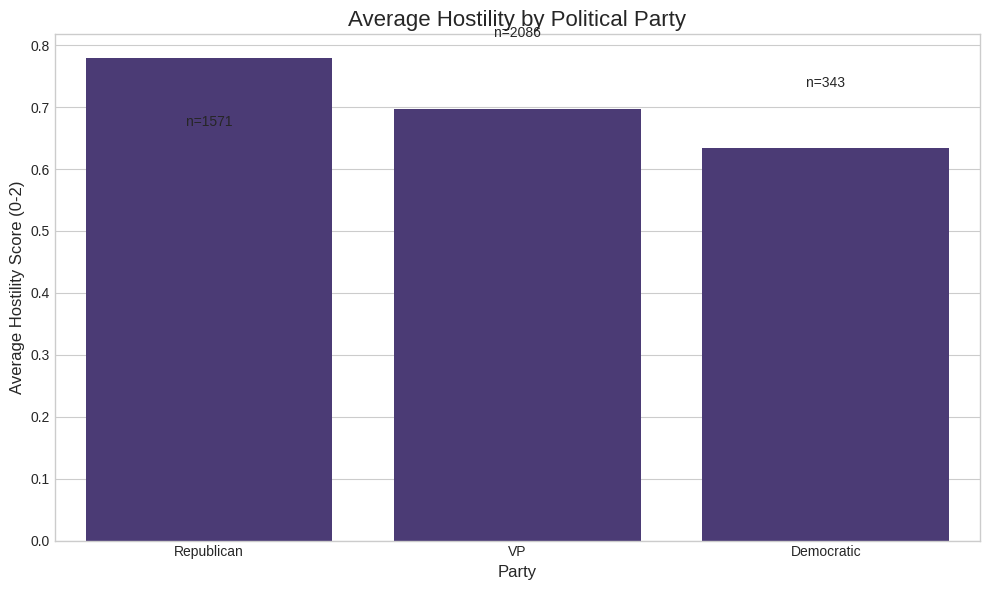

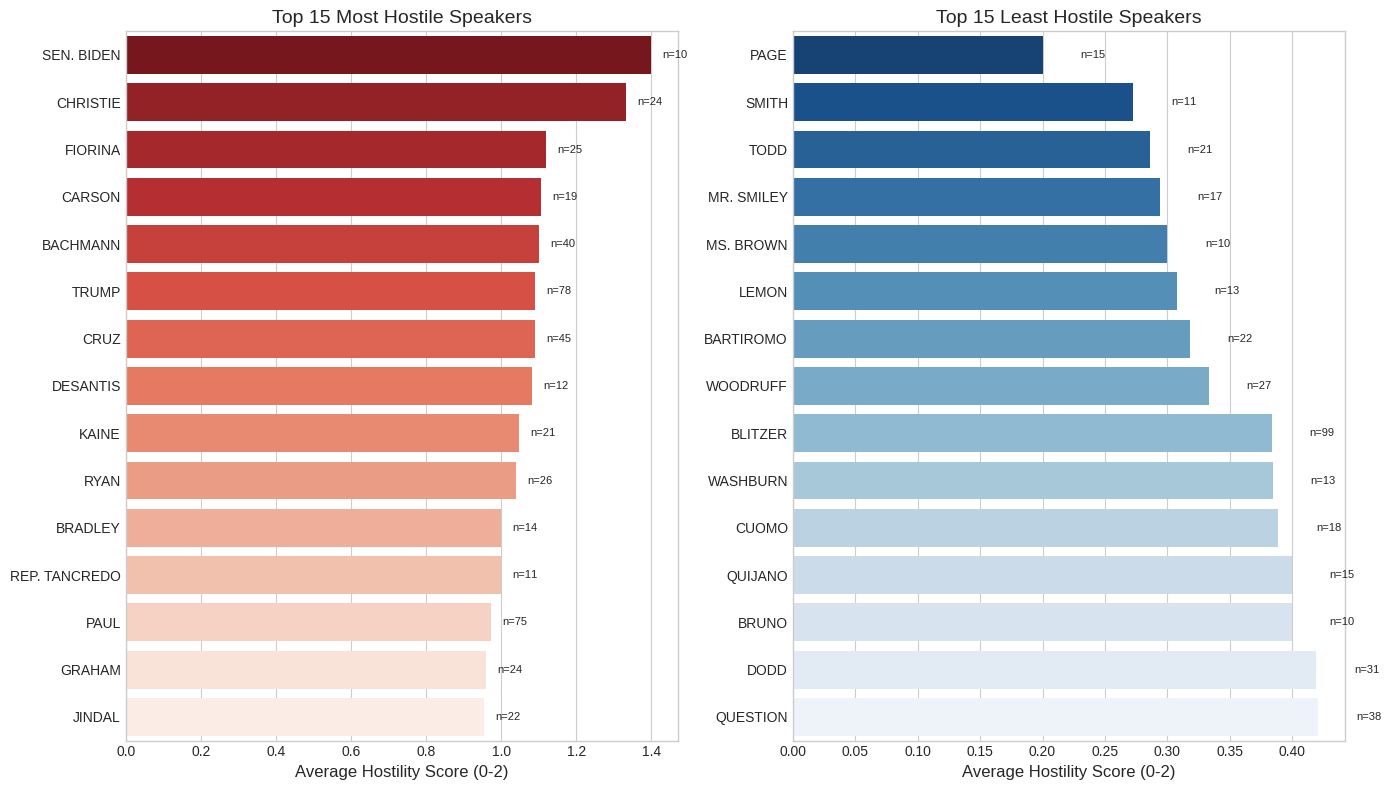

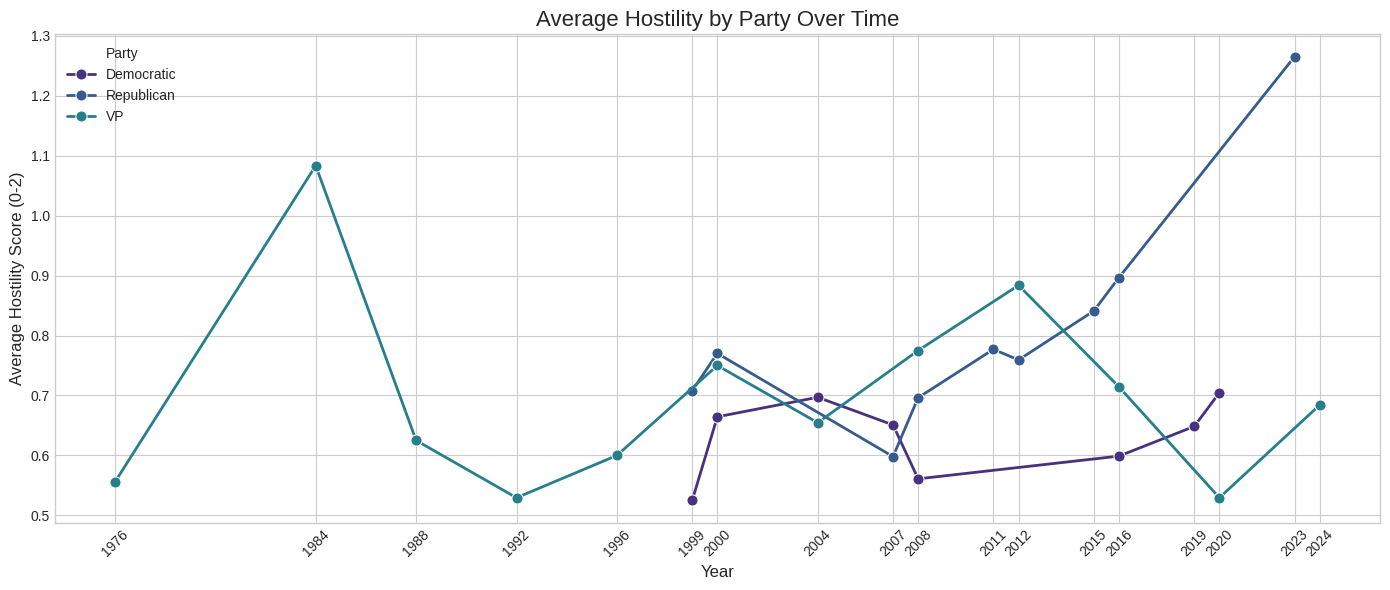

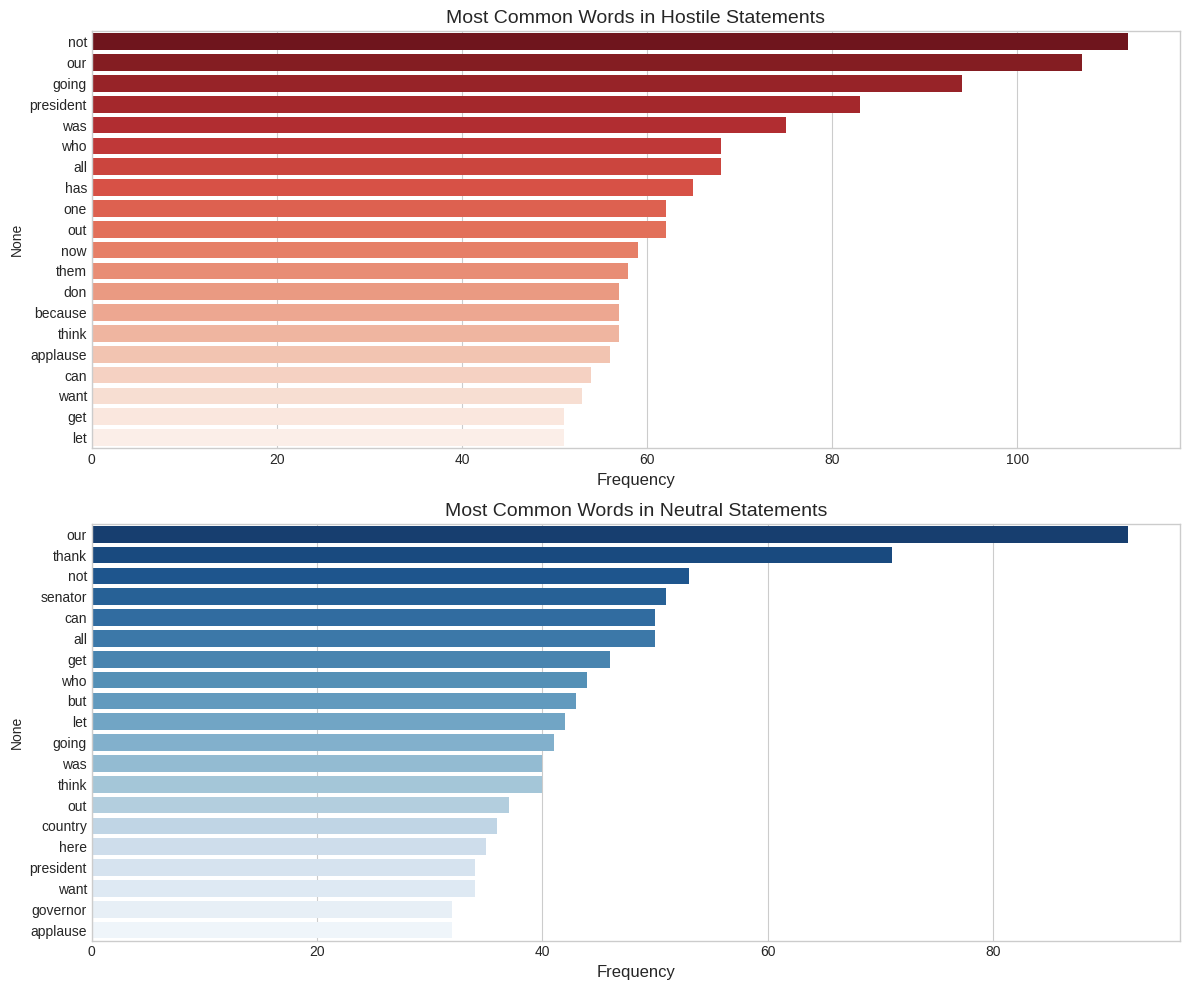

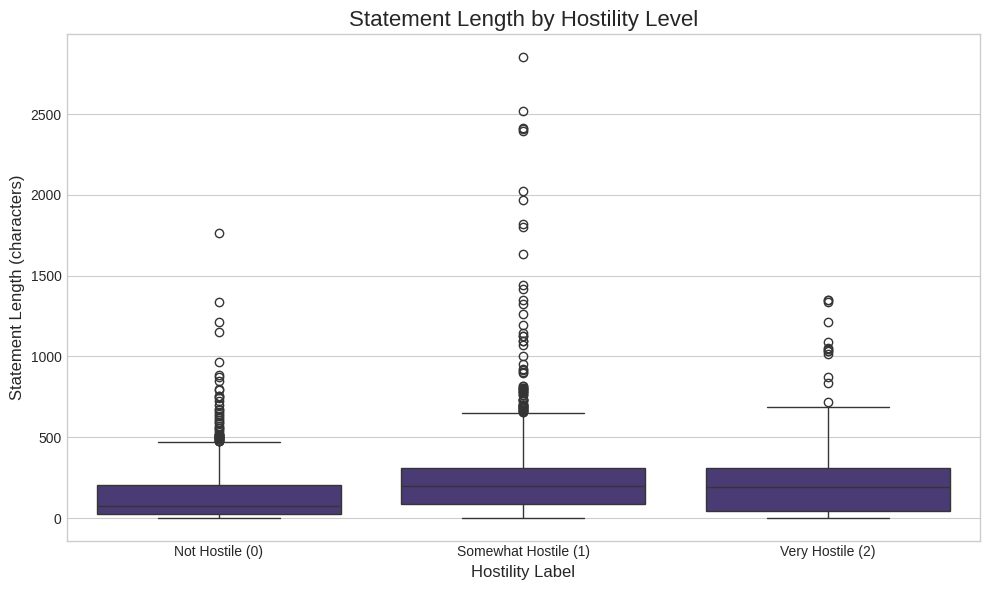

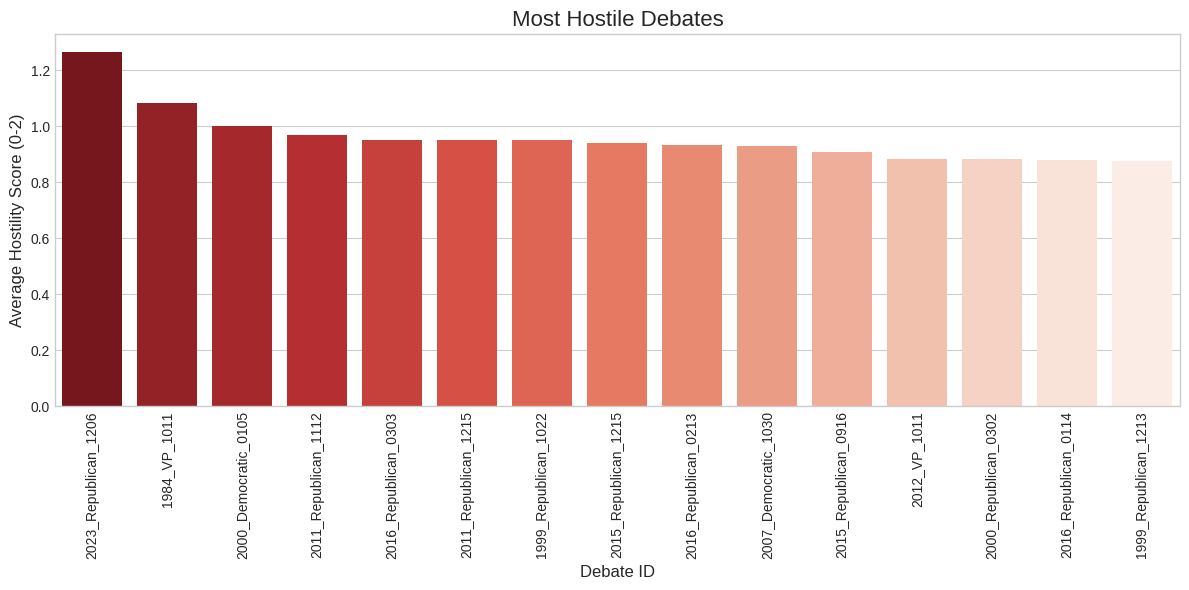

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Load the dataset with hostility labels
file_path = "vp_primary_debates_with_hostility.csv"
df = pd.read_csv(file_path)

print(f"Loaded dataset with {len(df)} statements")
print(f"Columns: {', '.join(df.columns)}")

# Basic statistics on hostility labels
print("\n=== Hostility Label Distribution ===")
hostility_counts = df['hostility_label'].value_counts().sort_index()
print(hostility_counts)
print(f"\nMean hostility score: {df['hostility_label'].mean():.3f}")
print(f"Statements with hostility > 0: {(df['hostility_label'] > 0).mean()*100:.1f}%")

# Create a function to extract year from debate_id if needed
if 'year' not in df.columns:
    try:
        # Try to extract year from debate_id (assuming format like "2020_Republican_0123")
        df['year'] = df['debate_id'].str.extract(r'(\d{4})').astype(int)
        print("\nExtracted year from debate_id")
    except:
        print("\nCouldn't extract year from debate_id - please ensure year column exists")

# ======================================================
# 1. Temporal analysis - hostility over time
# ======================================================
print("\n=== Hostility Trends Over Time ===")

# Group by year and calculate statistics
yearly_hostility = df.groupby('year')['hostility_label'].agg(['mean', 'count', 'std']).reset_index()
yearly_hostility = yearly_hostility.rename(columns={'mean': 'avg_hostility'})
print(yearly_hostility.sort_values('year'))

plt.figure(figsize=(14, 6))
sns.lineplot(data=yearly_hostility, x='year', y='avg_hostility',
             marker='o', linewidth=2, markersize=8)

# Add confidence interval (if enough data points per year)
for _, row in yearly_hostility.iterrows():
    if row['count'] >= 30:  # Only for years with sufficient data
        ci = 1.96 * row['std'] / np.sqrt(row['count'])  # 95% confidence interval
        plt.fill_between([row['year']-0.5, row['year']+0.5],
                        [row['avg_hostility']-ci, row['avg_hostility']-ci],
                        [row['avg_hostility']+ci, row['avg_hostility']+ci],
                        alpha=0.2)

plt.title('Average Hostility in Presidential Debates by Year', fontsize=16)
plt.ylabel('Average Hostility Score (0-2)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(yearly_hostility['year'], rotation=45)
plt.axhline(y=df['hostility_label'].mean(), color='r', linestyle='--',
           label=f'Overall Average: {df["hostility_label"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('hostility_over_time.png')

# ======================================================
# 2. Party Analysis - comparing hostility between parties
# ======================================================
print("\n=== Party-Based Hostility Analysis ===")

if 'party' in df.columns:
    party_hostility = df.groupby('party')['hostility_label'].agg(['mean', 'count', 'std']).reset_index()
    party_hostility = party_hostility.rename(columns={'mean': 'avg_hostility'})
    print(party_hostility.sort_values('avg_hostility', ascending=False))

    plt.figure(figsize=(10, 6))
    sns.barplot(data=party_hostility, x='party', y='avg_hostility',
               order=party_hostility.sort_values('avg_hostility', ascending=False)['party'])

    plt.title('Average Hostility by Political Party', fontsize=16)
    plt.ylabel('Average Hostility Score (0-2)', fontsize=12)
    plt.xlabel('Party', fontsize=12)

    # Add count labels
    for i, row in enumerate(party_hostility.itertuples()):
        plt.text(i, row.avg_hostility + 0.03, f'n={row.count}',
                ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig('hostility_by_party.png')
else:
    print("No 'party' column found in the dataset")

# ======================================================
# 3. Speaker Analysis - top speakers by hostility
# ======================================================
print("\n=== Speaker-Based Hostility Analysis ===")

# Filter out speakers with too few statements for meaningful analysis
min_statements = 10
speaker_hostility = df.groupby('speaker')['hostility_label'].agg(['mean', 'count', 'std'])
speaker_hostility = speaker_hostility[speaker_hostility['count'] >= min_statements]
speaker_hostility = speaker_hostility.sort_values('mean', ascending=False).reset_index()
speaker_hostility = speaker_hostility.rename(columns={'mean': 'avg_hostility'})

print(f"Top 10 most hostile speakers (with at least {min_statements} statements):")
print(speaker_hostility.head(10))

# Plot top and bottom speakers by hostility
plt.figure(figsize=(14, 8))
top_n = 15  # Number of speakers to show on each end

# Get top and bottom speakers
top_speakers = speaker_hostility.head(top_n)
bottom_speakers = speaker_hostility.tail(top_n).iloc[::-1]  # Reverse order

# Create subplot for top speakers
plt.subplot(1, 2, 1)
sns.barplot(data=top_speakers, x='avg_hostility', y='speaker', palette='Reds_r')
plt.title(f'Top {top_n} Most Hostile Speakers', fontsize=14)
plt.xlabel('Average Hostility Score (0-2)', fontsize=12)
plt.ylabel('')

# Add count labels
for i, row in enumerate(top_speakers.itertuples()):
    plt.text(row.avg_hostility + 0.03, i, f'n={row.count}',
            ha='left', va='center', fontsize=8)

# Create subplot for least hostile speakers
plt.subplot(1, 2, 2)
sns.barplot(data=bottom_speakers, x='avg_hostility', y='speaker', palette='Blues_r')
plt.title(f'Top {top_n} Least Hostile Speakers', fontsize=14)
plt.xlabel('Average Hostility Score (0-2)', fontsize=12)
plt.ylabel('')

# Add count labels
for i, row in enumerate(bottom_speakers.itertuples()):
    plt.text(row.avg_hostility + 0.03, i, f'n={row.count}',
            ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('hostility_by_speaker.png')

# ======================================================
# 4. Identify most hostile statements
# ======================================================
print("\n=== Most Hostile Statements ===")
most_hostile = df[df['hostility_label'] == 2].sample(min(10, df[df['hostility_label'] == 2].shape[0]))
print("Sample of statements labeled as very hostile (2):")
for i, row in enumerate(most_hostile.itertuples(), 1):
    print(f"\n{i}. Speaker: {row.speaker} ({row.year})")
    print(f"   \"{row.statement[:150]}{'...' if len(row.statement) > 150 else ''}\"")

# ======================================================
# 5. Party trends over time - how has hostility changed by party
# ======================================================
if 'party' in df.columns and 'year' in df.columns:
    print("\n=== Party Hostility Trends Over Time ===")

    party_year_hostility = df.groupby(['party', 'year'])['hostility_label'].agg(['mean', 'count']).reset_index()
    party_year_hostility = party_year_hostility.rename(columns={'mean': 'avg_hostility'})
    party_year_hostility = party_year_hostility[party_year_hostility['count'] >= 5]  # Only include groups with sufficient data

    plt.figure(figsize=(14, 6))
    sns.lineplot(data=party_year_hostility, x='year', y='avg_hostility', hue='party',
                 marker='o', linewidth=2, markersize=8)

    plt.title('Average Hostility by Party Over Time', fontsize=16)
    plt.ylabel('Average Hostility Score (0-2)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.xticks(sorted(party_year_hostility['year'].unique()), rotation=45)
    plt.legend(title='Party')
    plt.tight_layout()
    plt.savefig('party_hostility_over_time.png')

# ======================================================
# 6. Content analysis - What words are associated with hostility?
# ======================================================
print("\n=== Content Analysis of Hostile Statements ===")

# Function to extract most common words
def extract_common_words(statements, top_n=20):
    # Combine all statements into one text
    all_text = ' '.join(statements)

    # Simple tokenization (split by space and remove punctuation)
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())

    # Remove common stopwords
    stopwords = ['the', 'and', 'that', 'for', 'this', 'are', 'you', 'have', 'with',
                'your', 'they', 'been', 'from', 'what', 'would', 'about', 'there',
                'their', 'were', 'will', 'when', 'into', 'more', 'these', 'other',
                'some', 'than', 'only', 'know', 'just', 'like', 'people', 'very']

    filtered_words = [word for word in words if word not in stopwords]

    # Count occurrences
    word_counts = pd.Series(filtered_words).value_counts()

    return word_counts.head(top_n)

# Get statements by hostility level
hostile_statements = df[df['hostility_label'] == 2]['statement'].tolist()
neutral_statements = df[df['hostility_label'] == 0]['statement'].sample(min(len(hostile_statements),
                                                                           df[df['hostility_label'] == 0].shape[0]))

if hostile_statements:
    hostile_words = extract_common_words(hostile_statements)
    print("\nMost common words in highly hostile statements:")
    print(hostile_words)

    neutral_words = extract_common_words(neutral_statements)
    print("\nMost common words in neutral statements:")
    print(neutral_words)

    # Visualize the difference
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    sns.barplot(x=hostile_words.values, y=hostile_words.index, palette='Reds_r')
    plt.title('Most Common Words in Hostile Statements', fontsize=14)
    plt.xlabel('Frequency', fontsize=12)

    plt.subplot(2, 1, 2)
    sns.barplot(x=neutral_words.values, y=neutral_words.index, palette='Blues_r')
    plt.title('Most Common Words in Neutral Statements', fontsize=14)
    plt.xlabel('Frequency', fontsize=12)

    plt.tight_layout()
    plt.savefig('word_analysis.png')

# ======================================================
# 7. Statement length analysis - Is length related to hostility?
# ======================================================
print("\n=== Statement Length Analysis ===")

# Calculate statement length
df['statement_length'] = df['statement'].str.len()

# Group by hostility level
length_by_hostility = df.groupby('hostility_label')['statement_length'].agg(['mean', 'median', 'count']).reset_index()
print("Statement length by hostility level:")
print(length_by_hostility)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='hostility_label', y='statement_length')
plt.title('Statement Length by Hostility Level', fontsize=16)
plt.xlabel('Hostility Label', fontsize=12)
plt.ylabel('Statement Length (characters)', fontsize=12)
plt.xticks([0, 1, 2], ['Not Hostile (0)', 'Somewhat Hostile (1)', 'Very Hostile (2)'])
plt.tight_layout()
plt.savefig('length_by_hostility.png')

# ======================================================
# 8. Statistical tests - Is the difference in hostility significant?
# ======================================================
print("\n=== Statistical Analysis ===")

from scipy import stats

# Test if there's a significant difference in hostility between parties
if 'party' in df.columns and len(df['party'].unique()) > 1:
    parties = df['party'].unique()
    for i in range(len(parties)):
        for j in range(i+1, len(parties)):
            party1, party2 = parties[i], parties[j]
            hostility1 = df[df['party'] == party1]['hostility_label']
            hostility2 = df[df['party'] == party2]['hostility_label']

            # Skip if either group is too small
            if len(hostility1) < 30 or len(hostility2) < 30:
                continue

            # Perform t-test
            t_stat, p_value = stats.ttest_ind(hostility1, hostility2, equal_var=False)
            print(f"T-test between {party1} and {party2}:")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
            print(f"  Mean hostility {party1}: {hostility1.mean():.3f}")
            print(f"  Mean hostility {party2}: {hostility2.mean():.3f}\n")

# ======================================================
# 9. Debate-level analysis - Which debates were most hostile?
# ======================================================
print("\n=== Debate-level Hostility Analysis ===")

if 'debate_id' in df.columns:
    # Add debate_date if possible (extract from debate_id or other information)
    try:
        if 'date' not in df.columns:
            # Try to extract date from debate_id (this is a placeholder - adjust based on your actual format)
            date_pattern = r'(\d{4})_(\d{2})(\d{2})'
            df['debate_date'] = df['debate_id'].str.extract(date_pattern)
            df['debate_date'] = pd.to_datetime(df['debate_date'], format='%Y_%m_%d', errors='coerce')
    except:
        pass

    # Group by debate_id
    debate_hostility = df.groupby('debate_id')['hostility_label'].agg(['mean', 'count', 'std']).reset_index()
    debate_hostility = debate_hostility.rename(columns={'mean': 'avg_hostility'})
    debate_hostility = debate_hostility[debate_hostility['count'] >= 10]  # Only include debates with sufficient data

    # Sort by hostility
    debate_hostility = debate_hostility.sort_values('avg_hostility', ascending=False)

    print("Top 10 most hostile debates:")
    for i, row in enumerate(debate_hostility.head(10).itertuples(), 1):
        print(f"{i}. Debate ID: {row.debate_id}")
        print(f"   Average Hostility: {row.avg_hostility:.3f}")
        print(f"   Number of Statements: {row.count}")

    # Plot top debates by hostility
    plt.figure(figsize=(12, 6))
    sns.barplot(data=debate_hostility.head(15), x='debate_id', y='avg_hostility', palette='Reds_r')
    plt.title('Most Hostile Debates', fontsize=16)
    plt.xlabel('Debate ID', fontsize=12)
    plt.ylabel('Average Hostility Score (0-2)', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('most_hostile_debates.png')

# ======================================================
# 10. Generate summary report in Markdown format for easy sharing
# ======================================================
print("\n=== Generating Summary Report ===")

with open('hostility_analysis_report.md', 'w') as f:
    f.write("# Presidential Debate Hostility Analysis\n\n")
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d')}\n")
    f.write(f"Dataset: {file_path}\n")
    f.write(f"Total Statements Analyzed: {len(df)}\n\n")

    f.write("## Overview of Hostility Ratings\n\n")
    f.write("| Hostility Level | Count | Percentage |\n")
    f.write("|----------------|-------|------------|\n")
    for label, count in hostility_counts.items():
        percentage = count / len(df) * 100
        f.write(f"| {label} | {count} | {percentage:.1f}% |\n")

    f.write(f"\nMean Hostility Score: {df['hostility_label'].mean():.3f}\n\n")

    f.write("## Key Findings\n\n")
    f.write("1. **Temporal Trends**: ")
    if 'year' in df.columns:
        earliest_year = yearly_hostility['year'].min()
        latest_year = yearly_hostility['year'].max()
        earlier_avg = yearly_hostility[yearly_hostility['year'] == earliest_year]['avg_hostility'].iloc[0]
        latest_avg = yearly_hostility[yearly_hostility['year'] == latest_year]['avg_hostility'].iloc[0]
        change = latest_avg - earlier_avg

        f.write(f"From {earliest_year} to {latest_year}, average hostility has ")
        if change > 0:
            f.write(f"increased by {change:.3f} points (from {earlier_avg:.3f} to {latest_avg:.3f}).\n\n")
        elif change < 0:
            f.write(f"decreased by {-change:.3f} points (from {earlier_avg:.3f} to {latest_avg:.3f}).\n\n")
        else:
            f.write(f"remained unchanged at {earlier_avg:.3f}.\n\n")
    else:
        f.write("Temporal analysis not available due to missing year data.\n\n")

    if 'party' in df.columns:
        f.write("2. **Party Comparison**: ")
        most_hostile_party = party_hostility.iloc[0]
        least_hostile_party = party_hostility.iloc[-1]
        f.write(f"'{most_hostile_party['party']}' shows the highest average hostility ({most_hostile_party['avg_hostility']:.3f}), ")
        f.write(f"while '{least_hostile_party['party']}' shows the lowest ({least_hostile_party['avg_hostility']:.3f}).\n\n")

    f.write("3. **Speaker Analysis**: ")
    most_hostile_speaker = speaker_hostility.iloc[0]
    f.write(f"The most hostile speaker was '{most_hostile_speaker['speaker']}' with an average score of {most_hostile_speaker['avg_hostility']:.3f} ")
    f.write(f"across {most_hostile_speaker['count']} statements.\n\n")

    f.write("## Sample Hostile Statements\n\n")
    for i, row in enumerate(most_hostile.itertuples(), 1):
        f.write(f"{i}. **{row.speaker}** ({row.year}):\n")
        f.write(f"   > \"{row.statement[:150]}{'...' if len(row.statement) > 150 else ''}\"\n\n")

    f.write("## Visualizations\n\n")
    f.write("The following visualizations have been generated:\n\n")
    f.write("1. [Hostility Over Time](hostility_over_time.png)\n")
    if 'party' in df.columns:
        f.write("2. [Hostility by Party](hostility_by_party.png)\n")
        f.write("3. [Party Hostility Over Time](party_hostility_over_time.png)\n")
    f.write("4. [Hostility by Speaker](hostility_by_speaker.png)\n")
    f.write("5. [Word Analysis](word_analysis.png)\n")
    f.write("6. [Statement Length Analysis](length_by_hostility.png)\n")
    if 'debate_id' in df.columns:
        f.write("7. [Most Hostile Debates](most_hostile_debates.png)\n")

print("Analysis complete! Report saved as 'hostility_analysis_report.md'")